<a href="https://colab.research.google.com/github/Romanchenko-RS/ML/blob/main/%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B8_%D0%B4%D0%B5%D1%82%D0%B5%D0%BA%D1%86%D0%B8%D0%B8_%D0%B8_%D1%81%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D0%B8_%D0%A0%D0%BE%D0%BC%D0%B0%D0%BD%D1%87%D0%B5%D0%BD%D0%BA%D0%BE_%D0%A0_%D0%A1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт необходимых библиотек

In [46]:
import os
import requests
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import json
from glob import glob
from matplotlib import pyplot as plt
from tensorflow.keras.applications import vgg16
from tensorflow.keras import layers, models
from random import shuffle
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import csv

# Подготовка данных

In [20]:
def download_files_from_github(api_url, save_dir):
    response = requests.get(api_url)
    if response.status_code == 200:
        files = response.json()
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        for file_info in files:
            if file_info['type'] == 'file':
                file_url = file_info['download_url']
                file_name = file_info['name']
                save_path = os.path.join(save_dir, file_name)
                download_file(file_url, save_path)
            elif file_info['type'] == 'dir':
                sub_dir_url = file_info['url']
                sub_dir_name = file_info['name']
                sub_save_dir = os.path.join(save_dir, sub_dir_name)
                download_files_from_github(sub_dir_url, sub_save_dir)
    else:
        print(f"Не удалось получить список файлов, статус код: {response.status_code}")

def download_file(url, save_path):
    response = requests.get(url)
    if response.status_code == 200:
        with open(save_path, 'wb') as file:
            file.write(response.content)
        print(f"Файл {save_path} успешно скачан")
    else:
        print(f"Не удалось скачать файл {save_path}, статус код: {response.status_code}")

# URL API GitHub для папок и файлов
folders = [
    "https://api.github.com/repos/a4tunado/lectures/contents/007/data/fish/boxes",
    "https://api.github.com/repos/a4tunado/lectures/contents/007/data/fish/test_stg1",
    "https://api.github.com/repos/a4tunado/lectures/contents/007/data/fish/train"
]

# Загрузим файл fishdetector_weights.hdf5
file_url = "https://raw.githubusercontent.com/a4tunado/lectures/master/007/data/fish/fishdetector_weights.hdf5"
download_file(file_url, "/content/fishdetector_weights.hdf5")

# Скачивание всех файлов
for folder_url in folders:
    folder_name = folder_url.split('/')[-1]
    save_dir = os.path.join("/content", folder_name)
    download_files_from_github(folder_url, save_dir)

Файл /content/fishdetector_weights.hdf5 успешно скачан
Файл /content/boxes/alb_labels.json успешно скачан
Файл /content/boxes/bet_labels.json успешно скачан
Файл /content/boxes/dol_labels.json успешно скачан
Файл /content/boxes/lag_labels.json успешно скачан
Файл /content/boxes/shark_labels.json успешно скачан
Файл /content/boxes/yft_labels.json успешно скачан
Файл /content/test_stg1/img_00282.jpg успешно скачан
Файл /content/test_stg1/img_00618.jpg успешно скачан
Файл /content/test_stg1/img_01116.jpg успешно скачан
Файл /content/test_stg1/img_01222.jpg успешно скачан
Файл /content/test_stg1/img_02188.jpg успешно скачан
Файл /content/test_stg1/img_02890.jpg успешно скачан
Файл /content/test_stg1/img_02920.jpg успешно скачан
Файл /content/test_stg1/img_03140.jpg успешно скачан
Файл /content/test_stg1/img_03222.jpg успешно скачан
Файл /content/test_stg1/img_03439.jpg успешно скачан
Файл /content/test_stg1/img_03454.jpg успешно скачан
Файл /content/test_stg1/img_03584.jpg успешно скачан
Ф

In [21]:
TRAIN_PREFIX = '/content/train'

def load_annotations():
    boxes = dict()
    for path in glob('/content/boxes/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            for annotation in json.load(src):
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(
                    TRAIN_PREFIX, label.upper(), basename)
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
                if os.path.isfile(annotation['filename']):
                    boxes.setdefault(label, []).append(annotation)
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):
    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2,
                                color=color, thickness=4)
        return img

    scale_x, scale_y = 1., 1.

    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)

    img = _draw(img, annotation.get('annotations', []), scale_x, scale_y)

    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

# Визуализация разметки

Text(0.5, 1.0, '/content/train/LAG/img_07774.jpg 720x1280')

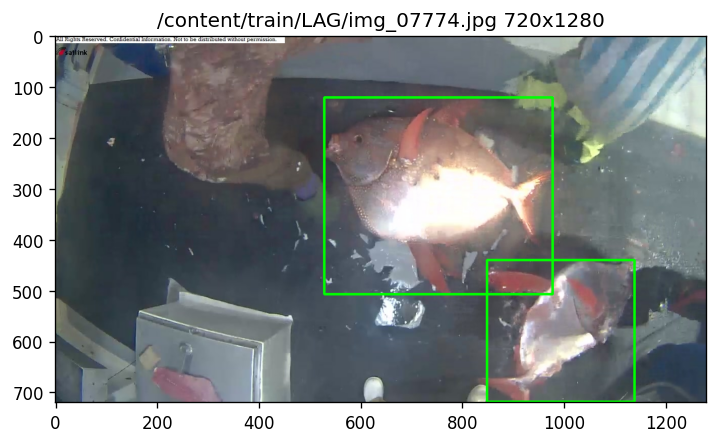

In [22]:
boxes = load_annotations()
pd.DataFrame(
[(k, len(v)) for k, v in boxes.items()],
columns=['class', 'count'])

annotation = boxes['lag'][0]
img = draw_boxes(annotation)

plt.figure(figsize=(7, 7), dpi=120)
plt.imshow(img)
plt.title('{} {}x{}'.format(
annotation['filename'], img.shape[0], img.shape[1]))

# Подготовим экстрактор признаков

In [23]:
# Экстрактор признаков
IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = vgg16.VGG16(weights='imagenet',
include_top=False,
input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

for layer in features.layers[:-5]:
    layer.trainable = False

feature_tensor = features.layers[-1].output
print(feature_tensor.shape)

(None, 23, 37, 512)


# Добавим сетку якорей

In [24]:
FEATURE_SHAPE = (feature_tensor.shape[1],
feature_tensor.shape[2])

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150.

ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

# Кодирование и декодирование якорей

In [25]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):
    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale

    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale

    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2

    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))

    intersection = dx * dy if (dx > 0 and dy > 0) else 0.

    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection

    return intersection / union

def encode_anchors(annotation, img_shape, iou_thr=0.5):
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
    FEATURE_SHAPE[1], 5), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    for rect in annotation['annotations']:
        scores = []
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))

        scores = sorted(scores, reverse=True)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]

        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            encoded[row, col] = [1., dx, dy, dw, dh]

    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
            logit, dx, dy, dw, dh = prediction[row, col]
            conf = _sigmoid(logit)
            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf})
    return rectangles

def non_max_suppression(rectangles, max_output_size, iou_threshold=0.5):
    if not rectangles:
        return rectangles

    boxes = [[r['y'],
              r['x'],
              r['y'] + r['height'],
              r['x'] + r['width']] for r in rectangles]
    scores = [r['conf'] for r in rectangles]
    indices = tf.image.non_max_suppression(np.array(boxes),
                                           np.array(scores),
                                           max_output_size,
                                           iou_threshold)

    return [rectangles[i] for i in indices]

# Энкодинг/декодинг якорей

Text(0.5, 1.0, '/content/train/LAG/img_07774.jpg 720x1280')

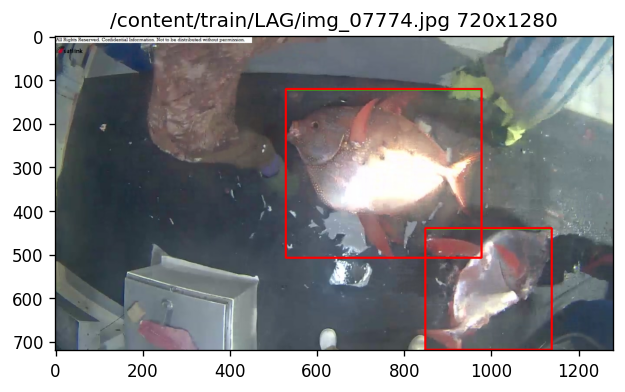

In [26]:
annotation = boxes['lag'][0]

encoded = encode_anchors(annotation,
img_shape=(IMG_HEIGHT, IMG_WIDTH),
iou_thr=0.5)

decoded = decode_prediction(encoded, conf_thr=0.7)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(annotation, decoded))
plt.title('{} {}x{}'.format(
annotation['filename'], img.shape[0], img.shape[1]))

# Функция потерь

In [27]:
# Функция потерь
K = tf.keras.backend

def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 0],
                                      y_pred[..., 0],
                                      from_logits=True)
    return conf_loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 1:] - y_pred[..., 1:])
    square_loss = 0.5 * K.square(y_true[..., 1:] - y_pred[..., 1:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]

    y_true = K.reshape(y_true, (batch_size, -1, 5))
    y_pred = K.reshape(y_pred, (batch_size, -1, 5))

    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)

    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)

    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 0], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)

    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 0], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])

    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)

    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)

    return total_conf_loss + 0.5 * loc_loss

# Загрузка данных для обучения

In [28]:
# Используем только часть данных для ускорения обучения
def load_annotations(sample_size=32):
    boxes = dict()
    all_paths = glob('/content/boxes/*.json')
    for path in all_paths[:sample_size]:  # Ограничиваем количество файлов
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            for annotation in json.load(src):
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(
                    TRAIN_PREFIX, label.upper(), basename)
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
                if os.path.isfile(annotation['filename']):
                    boxes.setdefault(label, []).append(annotation)
    return boxes

# Добавляем выход детектора

In [29]:
# Добавляем выход детектора
output = layers.BatchNormalization()(feature_tensor)

output = layers.Conv2D(5,
kernel_size=(1, 1),
activation='linear',
kernel_regularizer='l2')(output)

model = models.Model(inputs=features.inputs, outputs=output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 750, 1200, 3)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 750, 1200, 64)       │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 750, 1200, 64)       │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 375, 600, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 375, 600, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 375, 600, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 187, 300, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 187, 300, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 187, 300, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 187, 300, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 93, 150, 256)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 93, 150, 512)        │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 93, 150, 512)        │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 93, 150, 512)        │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 46, 75, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 46, 75, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 46, 75, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 46, 75, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 23, 37, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 23, 37, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 23, 37, 5)           │           2,5

 Total params: 14,719,301 (56.15 MB)

 Trainable params: 7,083,013 (27.02 MB)

 Non-trainable params: 7,636,288 (29.13 MB)

# Обучение модели

In [35]:
def data_generator(boxes, batch_size=4):
    keys = list(boxes.keys())
    while True:
        shuffle(keys)
        batch_X, batch_Y = [], []
        for key in keys:
            annotations = boxes[key]
            shuffle(annotations)
            for annotation in annotations:
                img = cv2.imread(annotation['filename'])
                img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
                encoded = encode_anchors(annotation, img.shape)
                batch_X.append(img)
                batch_Y.append(encoded)
                if len(batch_X) == batch_size:
                    yield np.array(batch_X), np.array(batch_Y)
                    batch_X, batch_Y = [], []

# Обучение
adam = tf.keras.optimizers.Adam(learning_rate=3e-4, decay=1e-6)
model.compile(optimizer=adam,
              loss=total_loss,
              metrics=[confidence_loss])
batch_size = 4

gen = data_generator(boxes, batch_size=batch_size)
steps_per_epoch = int(sum(map(len, boxes.values()), 0) / batch_size)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'fishdetector.keras',  # изменение расширения файла
    monitor='loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch')  # изменение аргумента save_freq

# Уменьшаем количество эпох
model.fit(gen,
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          callbacks=[checkpoint])

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 43s/step - confidence_loss: 0.9102 - loss: 6.3852 
Epoch 1: loss improved from inf to 5.13679, saving model to fishdetector.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 568s 43s/step - confidence_loss: 0.9097 - loss: 6.2960
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 43s/step - confidence_loss: 0.7932 - loss: 3.3902 
Epoch 2: loss improved from 5.13679 to 3.56941, saving model to fishdetector.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 564s 43s/step - confidence_loss: 0.7924 - loss: 3.4030
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 43s/step - confidence_loss: 0.7001 - loss: 1.9373 
Epoch 3: loss improved from 3.56941 to 1.93413, saving model to fishdetector.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 561s 43s/step - confidence_loss: 0.6996 - loss: 1.9371
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 43s/step - confidence_loss: 0.7045 - loss: 1.5475 
Epoch 4: loss improved from 1.93413 to 1.48775, saving model to fishdetector.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 561s 43s/step - confidence_loss

# Проверка работы детектора

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


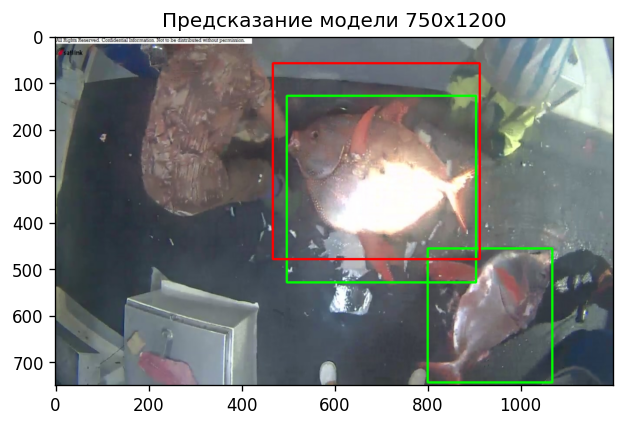

In [41]:
# Результат работы детектора
model.load_weights('/content/fishdetector_weights.hdf5')
annotation = boxes['lag'][0]

# Загружаем и изменяем размер изображения
sample_img = load_img(annotation['filename'], target_size=(IMG_HEIGHT, IMG_WIDTH))
sample_img = img_to_array(sample_img)

# Добавляем измерение для батча
sample_img = np.expand_dims(sample_img, axis=0)

pred = model.predict(sample_img)

decoded = decode_prediction(pred[0], conf_thr=0.2)
decoded = non_max_suppression(decoded,
                              max_output_size=5,
                              iou_threshold=0.1)

plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(annotation, decoded, (IMG_WIDTH, IMG_HEIGHT))
if img.shape:
    plt.imshow(img)
    plt.title('Предсказание модели {}x{}'.format(img.shape[0], img.shape[1]))
else:
    print("Ошибка: img не содержит shape")

# Проверка работы на тестовой выборке

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


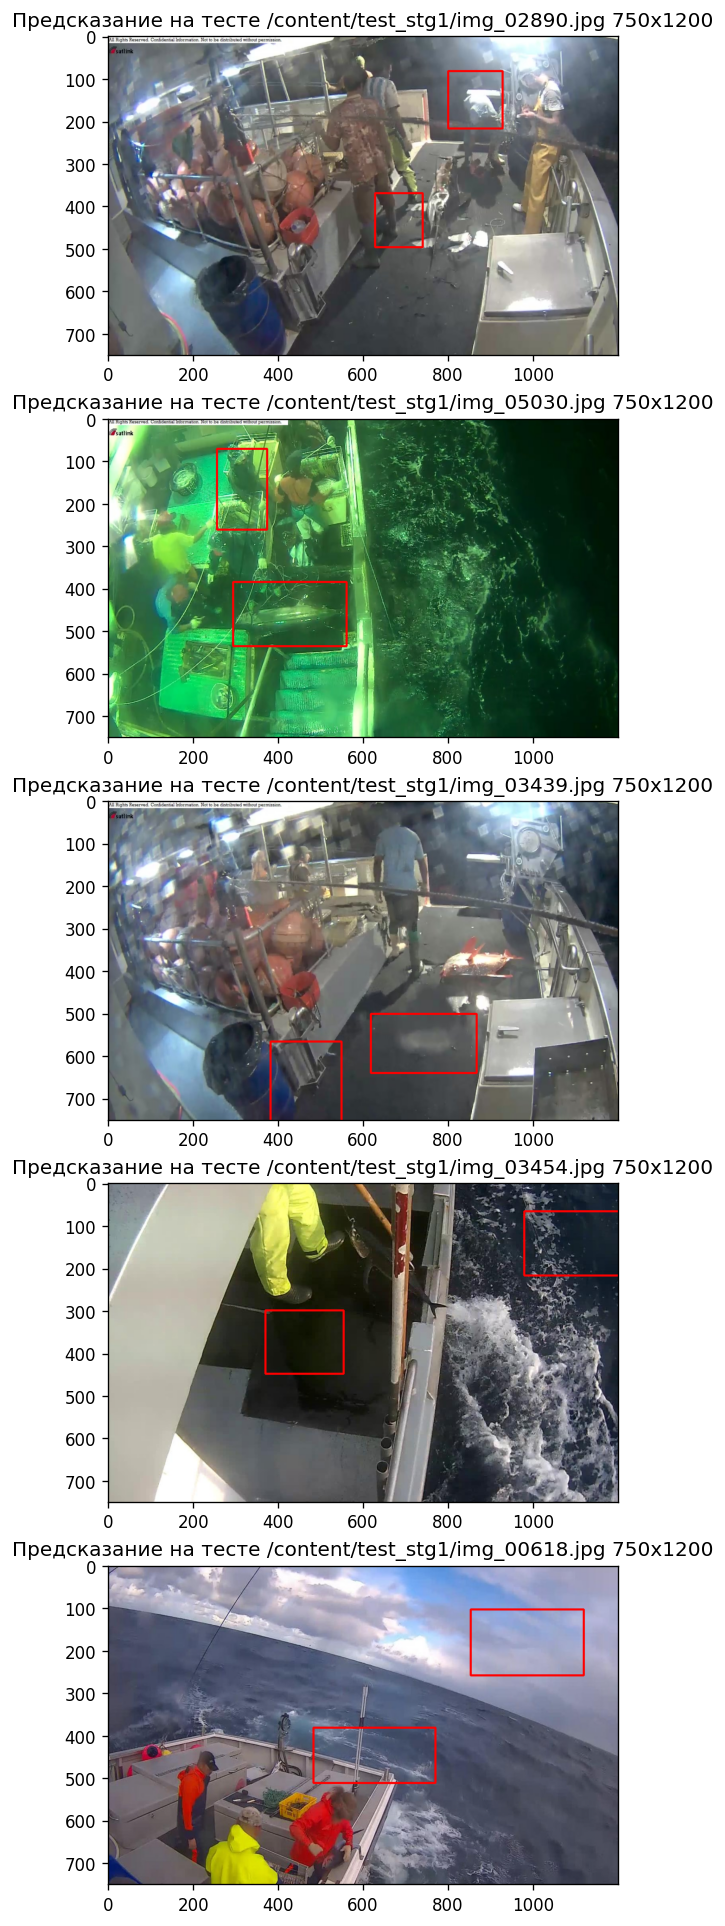

In [44]:
# Визуализируем предсказание на тесте
test_images = glob('/content/test_stg1/*.jpg')[:5]

plt.figure(figsize=(6, 4 * len(test_images)), dpi=120)

for i, filename in enumerate(test_images):
    # Загружаем и изменяем размер изображения
    sample_img = load_img(filename, target_size=(IMG_HEIGHT, IMG_WIDTH))
    sample_img = img_to_array(sample_img)

    # Добавляем измерение для батча
    sample_img = np.expand_dims(sample_img, axis=0)

    pred = model.predict(sample_img)

    decoded = decode_prediction(pred[0], conf_thr=0.0)
    decoded = non_max_suppression(decoded, max_output_size=2, iou_threshold=0.1)

    plt.subplot(len(test_images), 1, i + 1)
    img = draw_boxes({'filename': filename}, decoded, (IMG_WIDTH, IMG_HEIGHT))
    if img.shape:
        plt.imshow(img)
        plt.title('Предсказание на тесте {} {}x{}'.format(filename, img.shape[0], img.shape[1]))
    else:
        print("Ошибка: img не содержит shape для файла", filename)

plt.show()

# Предсказание класса рыбы

In [48]:
# Классы рыб
CLASSES = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

# Функция для предсказания вероятностей классов
def predict_classes(model, image_path):
    # Загружаем и изменяем размер изображения
    img = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img = img_to_array(img)

    # Добавляем измерение для батча
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img)[0]
    decoded = decode_prediction(pred, conf_thr=0.0)
    decoded = non_max_suppression(decoded, max_output_size=2, iou_threshold=0.1)

    # Предполагаем, что вероятность класса рыбы пропорциональна количеству детекций
    class_probs = {cls: 0 for cls in CLASSES}
    for rect in decoded:
        class_probs[rect.get('class', 'OTHER')] += rect['conf']  # Дефолтный класс OTHER

    total_conf = sum(class_probs.values())
    if total_conf > 0:
        class_probs = {cls: conf/total_conf for cls, conf in class_probs.items()}

    return class_probs

# Подготовка файла с предсказаниями
def prepare_submission_file(test_images, model, output_file='submission.csv'):
    with open(output_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['image'] + CLASSES)

        for image_path in test_images:
            class_probs = predict_classes(model, image_path)
            row = [os.path.basename(image_path)] + [class_probs.get(cls, 0) for cls in CLASSES]
            writer.writerow(row)

# Список тестовых изображений
test_images = glob('/content/test_stg1/*.jpg')

# Проверка количества тестовых изображений
print(f"Количество тестовых изображений: {len(test_images)}")

# Подготовка файла с предсказаниями
prepare_submission_file(test_images, model, output_file='/content/submission.csv')

# Скачивание файла
from google.colab import files
files.download('/content/submission.csv')

Количество тестовых изображений: 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Выводы

По результатам детекции рыб на тестовой выборке можно сделать вывод, что данная модель не обладает достаточным качеством, чтобы находить рыб на фотографиях.

Для улучшения качества работы модели необходимо более тонко настроить гиперпараметры модели, а также увеличить количество эпох обучения.

Файл с предсказаниями отнёс всех найденных рыб к классу "остальные".
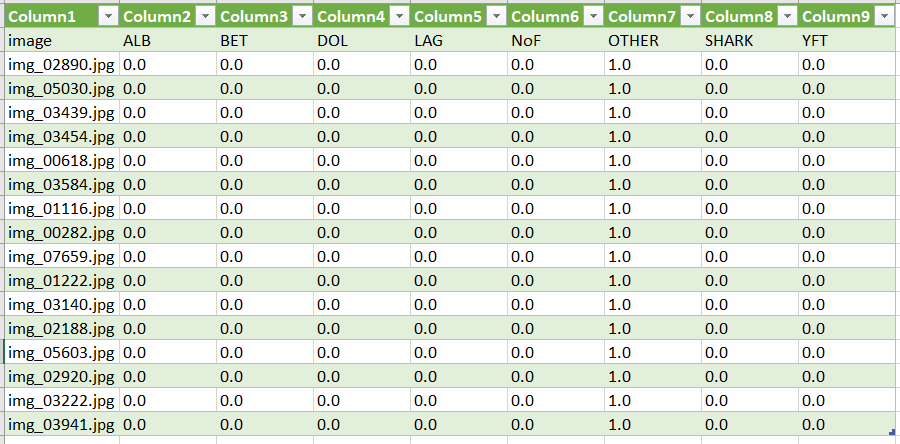